## 1. Setup

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss,
    average_precision_score, confusion_matrix, roc_curve, precision_recall_curve,
)
import lightgbm as lgb

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
competition_dataset = Path('/kaggle/input/icr-identify-age-related-conditions')

In [3]:
df_train = pd.read_csv(competition_dataset / 'train.csv')
df_test = pd.read_csv(competition_dataset / 'test.csv')

print(f'Training Dataset Shape: {df_train.shape}')
print(f'Test Dataset Shape: {df_test.shape}')

Training Dataset Shape: (617, 58)
Test Dataset Shape: (5, 57)


## 2. Metrics

In [4]:
def round_probabilities(probabilities, threshold):

    """
    Round probabilities to labels based on the given threshold

    Parameters
    ----------
    probabilities : numpy.ndarray of shape (n_samples)
        Predicted probabilities

    threshold: float
        Rounding threshold

    Returns
    -------
    labels : numpy.ndarray of shape (n_samples)
        Rounded probabilities
    """

    labels = np.zeros_like(probabilities, dtype=np.uint8)
    labels[probabilities >= threshold] = 1

    return labels


def specificity_score(y_true, y_pred):

    """
    Calculate specificity score (true-negative rate) of predicted labels

    Parameters
    ----------
    y_true: numpy.ndarray of shape (n_samples)
        Ground-truth labels

    y_pred: numpy.ndarray of shape (n_samples)
        Predicted labels

    Returns
    -------
    score: float
        Specificity score between 0 and 1
    """

    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    score = tn / (tn + fp)

    return score


def classification_scores(y_true, y_pred, threshold=0.5):

    """
    Calculate binary classification metrics on predicted probabilities and labels

    Parameters
    ----------
    y_true: numpy.ndarray of shape (n_samples)
        Ground-truth labels

    y_pred: numpy.ndarray of shape (n_samples)
        Predicted probabilities

    threshold: float
        Rounding threshold

    Returns
    -------
    scores: dict
        Dictionary of classification scores
    """

    y_pred_labels = round_probabilities(y_pred, threshold=threshold)
    scores = {
        'log_loss': log_loss(y_true, y_pred),
        'accuracy': accuracy_score(y_true, y_pred_labels),
        'precision': precision_score(y_true, y_pred_labels),
        'recall': recall_score(y_true, y_pred_labels),
        'specificity': specificity_score(y_true, y_pred_labels),
        'f1': f1_score(y_true, y_pred_labels),
        'roc_auc': roc_auc_score(y_true, y_pred),
        'average_precision': average_precision_score(y_true, y_pred)
    }

    return scores


def classification_curves(y_true, y_pred):

    """
    Calculate binary classification curves on predicted probabilities

    Parameters
    ----------
    y_true: numpy.ndarray of shape (n_samples)
        Ground-truth labels

    y_pred: numpy.ndarray of shape (n_samples)
        Predicted probabilities

    Returns
    -------
    curves: dict
        Dictionary of classification curves
    """

    curves = {
        'roc': roc_curve(y_true, y_pred),
        'precision_recall': precision_recall_curve(y_true, y_pred),
    }

    return curves


## 3. Visualization

In [5]:
def visualize_feature_importance(df_feature_importance, path=None):

    """
    Visualize feature importance in descending order

    Parameters
    ----------
    df_feature_importance: pandas.DataFrame of shape (n_features, n_splits)
        Dataframe of feature importance

    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """

    n_splits = df_feature_importance.shape[1] - 2

    fig, ax = plt.subplots(figsize=(24, 20), dpi=100)
    ax.barh(
        range(len(df_feature_importance)),
        df_feature_importance['mean'],
        xerr=df_feature_importance['std'],
        ecolor='black',
        capsize=10,
        align='center',
    )
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks(range(len(df_feature_importance)))
    ax.set_yticklabels([f'{k} ({v:.2f})' for k, v in df_feature_importance['mean'].to_dict().items()])
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title(f'Mean and Std Feature Importance of {n_splits} Models', size=20, pad=15)
    plt.gca().invert_yaxis()

    if path is None:
        plt.show()
    else:
        plt.savefig(path, bbox_inches='tight')
        plt.close(fig)


def visualize_scores(df_scores, path=None):

    """
    Visualize scores of the models

    Parameters
    ----------
    df_scores: pandas.DataFrame of shape (n_splits, n_metrics)
        Dataframe with multiple scores and metrics

    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """

    # Create mean and std of scores for error bars
    df_scores = df_scores.T
    n_scores = df_scores.shape[1]
    column_names = df_scores.columns.to_list()
    df_scores['mean'] = df_scores[column_names].mean(axis=1)
    df_scores['std'] = df_scores[column_names].std(axis=1).fillna(0)

    fig, ax = plt.subplots(figsize=(32, 8))
    ax.barh(
        y=np.arange(df_scores.shape[0]),
        width=df_scores['mean'],
        xerr=df_scores['std'],
        align='center',
        ecolor='black',
        capsize=10
    )
    ax.set_yticks(np.arange(df_scores.shape[0]))
    ax.set_yticklabels([
        f'{metric}\n{mean:.4f} (±{std:.4f})' for metric, mean, std in zip(
            df_scores.index,
            df_scores['mean'].values,
            df_scores['std'].values
        )
    ])
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelsize=15, pad=10)
    ax.tick_params(axis='y', labelsize=15, pad=10)
    ax.set_title(f'Mean and Std Scores of {n_scores} Model(s)', size=20, pad=15)

    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)

        
def visualize_roc_curves(roc_curves, path=None):

    """
    Visualize ROC curves of the models

    Parameters
    ----------
    roc_curves: array-like of shape (n_models, 3)
        List of ROC curves (tuple of false positive rates, true positive rates and thresholds)

    path: path-like str or None
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """

    n_scores = len(roc_curves)
    tprs_interpolated = []
    aucs = []
    mean_false_positive_rate = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(16, 16))

    # Plot random guess curve
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2.5, color='r', alpha=0.75)
    # Plot individual ROC curves of multiple models
    for fprs, tprs, _ in roc_curves:
        tprs_interpolated.append(np.interp(mean_false_positive_rate, fprs, tprs))
        tprs_interpolated[-1][0] = 0.0
        roc_auc = auc(fprs, tprs)
        aucs.append(roc_auc)
        ax.plot(fprs, tprs, lw=1, alpha=0.1)

    # Plot mean ROC curve of N models
    mean_tpr = np.mean(tprs_interpolated, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_false_positive_rate, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_false_positive_rate, mean_tpr, color='b', label=f'Mean ROC Curve (AUC: {mean_auc:.4f} ±{std_auc:.4f})', lw=2.5, alpha=0.9)

    # Plot confidence interval of ROC curves
    std_tpr = np.std(tprs_interpolated, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_false_positive_rate, tprs_lower, tprs_upper, color='grey', alpha=0.2, label='±1 sigma')

    ax.set_xlabel('False Positive Rate', size=15, labelpad=12)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=12)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_title(f'Mean and Std ROC curves of {n_scores} Models', size=20, pad=15)
    ax.legend(loc='lower right', prop={'size': 14})

    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)


## 4. Preprocessing

In [6]:
label_encoder = LabelEncoder()
df_train['EJ'] = label_encoder.fit_transform(df_train['EJ'])
df_test['EJ'] = label_encoder.transform(df_test['EJ'])

## 5. Training

In [7]:
features = [column for column in df_train.columns.tolist() if column != 'Id' and column != 'Class']
target = 'Class'

n_splits = 5
shuffle = True
random_state = 42

model_parameters = {
    'num_leaves': 16,
    'learning_rate': 0.01,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.8,
    'feature_fraction_bynode': 1.0,
    'min_data_in_leaf': 8,
    'min_gain_to_split': 0,
    'lambda_l1': 0.,
    'lambda_l2': 0.,
    'max_bin': 255,
    'max_depth': -1,
    'boost_from_average': True,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'seed': 42,
    'feature_fraction_seed': 42,
    'bagging_seed': 42,
    'drop_seed': 42,
    'data_random_seed': 42,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'n_jobs': -1,
}

fit_parameters = {
    'boosting_rounds': 250,
    'log_evaluation': 250,
    'early_stopping': 999999,
}

In [8]:
df_test['lightgbm_prediction'] = 0

df_feature_importance_gain = pd.DataFrame(
    data=np.zeros((len(features), n_splits)),
    index=features,
    columns=[f'fold_{fold}' for fold in range(1, n_splits + 1)]
)
df_feature_importance_split = pd.DataFrame(
    data=np.zeros((len(features), n_splits)),
    index=features,
    columns=[f'fold_{fold}' for fold in range(1, n_splits + 1)]
)
scores = []
    
skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

for fold, (training_idx, validation_idx) in enumerate(skf.split(X=df_train, y=df_train['Class']), 1):

    print(
        f'''
        Fold {fold}
        Training Shape: ({len(training_idx)}, {len(features)}) - Target Mean: {df_train.loc[training_idx, target].mean():.4f}
        Validation: ({len(validation_idx)}, {len(features)}) - Target Mean: {df_train.loc[validation_idx, target].mean():.4f}
        '''
    )

    training_dataset = lgb.Dataset(df_train.loc[training_idx, features], label=df_train.loc[training_idx, target])
    validation_dataset = lgb.Dataset(df_train.loc[validation_idx, features], label=df_train.loc[validation_idx, target])

    # Set model parameters, train parameters, callbacks and start training
    model = lgb.train(
        params=model_parameters,
        train_set=training_dataset,
        valid_sets=[training_dataset, validation_dataset],
        num_boost_round=fit_parameters['boosting_rounds'],
        callbacks=[
            lgb.early_stopping(fit_parameters['early_stopping']),
            lgb.log_evaluation(fit_parameters['log_evaluation'])
        ]
    )

    df_feature_importance_gain[f'fold_{fold}'] = model.feature_importance(importance_type='gain')
    df_feature_importance_split[f'fold_{fold}'] = model.feature_importance(importance_type='split')
    
    val_predictions = model.predict(df_train.loc[validation_idx, features])
    df_train.loc[validation_idx, 'lightgbm_prediction'] = val_predictions
    val_scores = classification_scores(
        y_true=df_train.loc[validation_idx, target],
        y_pred=df_train.loc[validation_idx, 'lightgbm_prediction'],
    )
    scores.append(val_scores)
    print(f'Fold {fold} - Validation Scores: {json.dumps(val_scores, indent=2)}')
    
    test_predictions = model.predict(df_test.loc[:, features])
    df_test['lightgbm_prediction'] += (test_predictions / n_splits)




        Fold 1
        Training Shape: (493, 56) - Target Mean: 0.1744
        Validation: (124, 56) - Target Mean: 0.1774
        
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 86, number of negative: 407
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7352
[LightGBM] [Info] Number of data points in the train set: 493, number of used features: 56
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174442 -> initscore=-1.554466
[LightGBM] [Info] Start training from score -1.554466
Training until validation scores don't improve for 999999 rounds
[250]	training's binary_logloss: 0.0545446	valid_1's binary_logloss: 0.176053
Did not meet early stopping. Best iteration is:
[250]	training's binary_lo

## 6. Evaluation

In [9]:
# Display validation scores
df_scores = pd.DataFrame(scores)
for fold, scores in df_scores.iterrows():
    print(f'Fold {int(fold) + 1} - Validation Scores: {json.dumps(scores.to_dict(), indent=2)}')
print(
    f'''
    LightGBM Mean Validation Scores
    {json.dumps(df_scores.mean(axis=0).to_dict(), indent=2)}
    and Standard Deviations
    ±{json.dumps(df_scores.std(axis=0).to_dict(), indent=2)}
    '''
)

oof_scores = classification_scores(
    y_true=df_train.loc[:, target],
    y_pred=df_train.loc[:, 'lightgbm_prediction'],
)
print(f'OOF Scores: {json.dumps(oof_scores, indent=2)}')

Fold 1 - Validation Scores: {
  "log_loss": 0.17605267335931557,
  "accuracy": 0.9112903225806451,
  "precision": 0.9230769230769231,
  "recall": 0.5454545454545454,
  "specificity": 0.9901960784313726,
  "f1": 0.6857142857142856,
  "roc_auc": 0.9915329768270944,
  "average_precision": 0.9460763838406276
}
Fold 2 - Validation Scores: {
  "log_loss": 0.21424696196725368,
  "accuracy": 0.9032258064516129,
  "precision": 0.9166666666666666,
  "recall": 0.5,
  "specificity": 0.9901960784313726,
  "f1": 0.6470588235294118,
  "roc_auc": 0.9518716577540107,
  "average_precision": 0.8777905579312044
}
Fold 3 - Validation Scores: {
  "log_loss": 0.1745438330086142,
  "accuracy": 0.926829268292683,
  "precision": 0.9333333333333333,
  "recall": 0.6363636363636364,
  "specificity": 0.9900990099009901,
  "f1": 0.7567567567567568,
  "roc_auc": 0.9842484248424843,
  "average_precision": 0.9415054961378491
}
Fold 4 - Validation Scores: {
  "log_loss": 0.26991034075047055,
  "accuracy": 0.902439024390

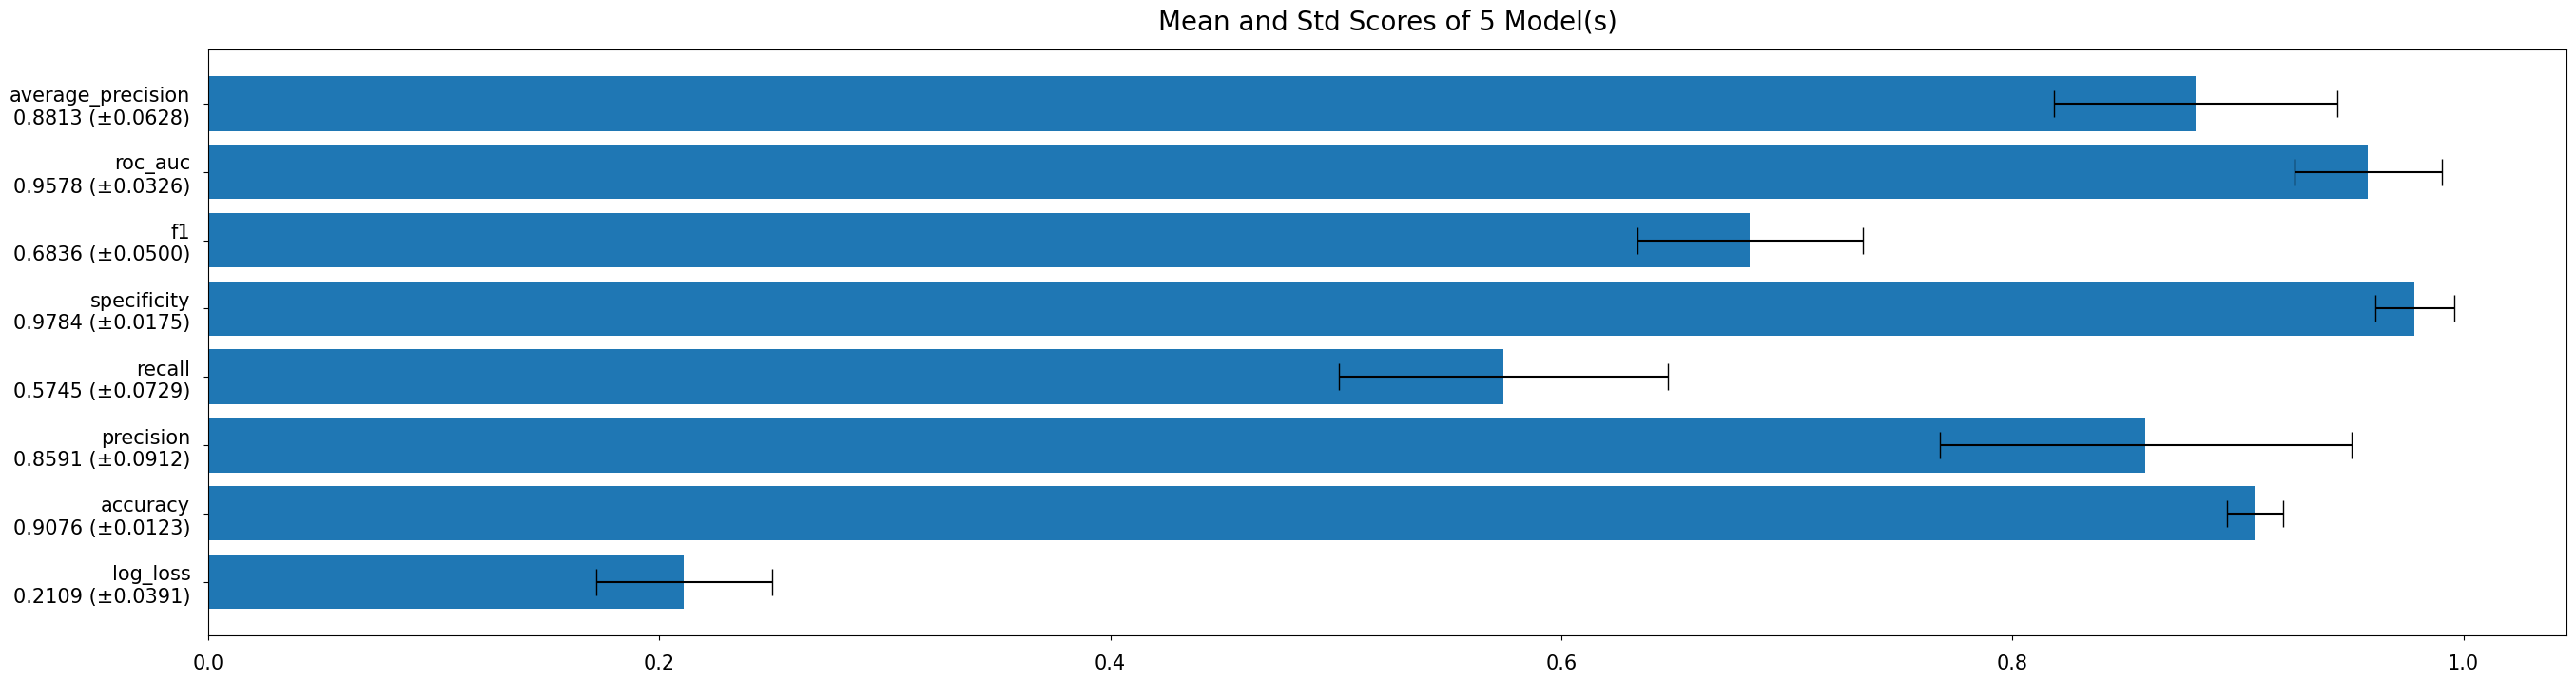

In [10]:
visualize_scores(df_scores=df_scores)

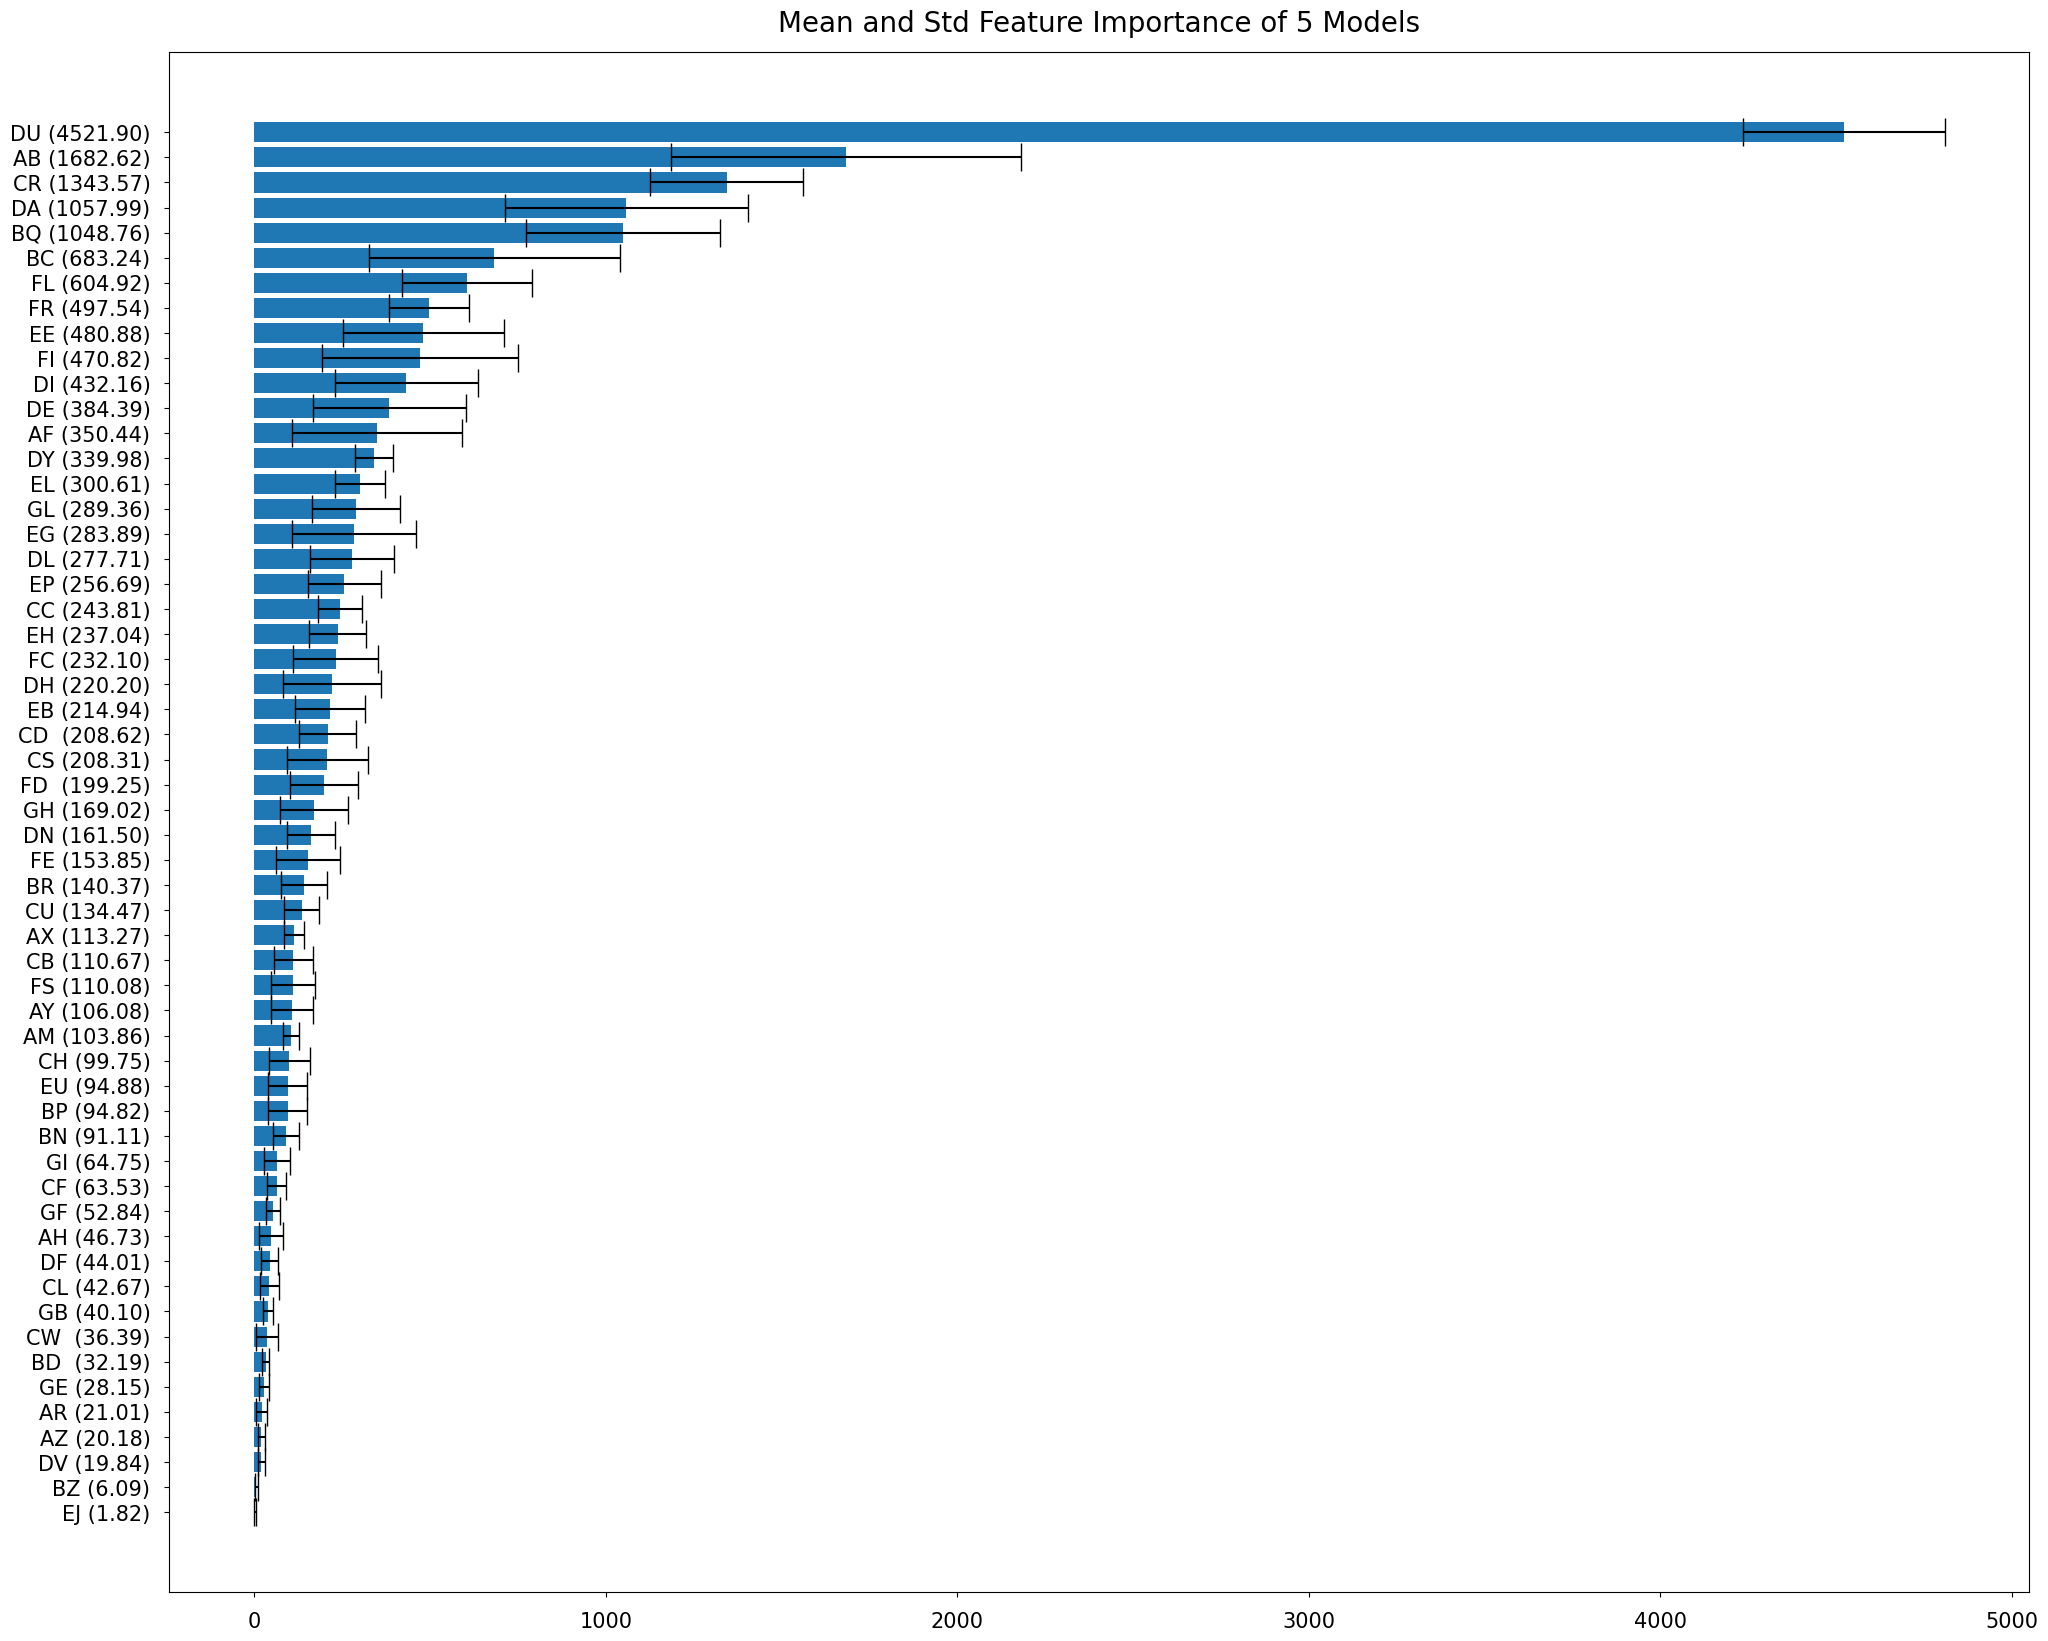

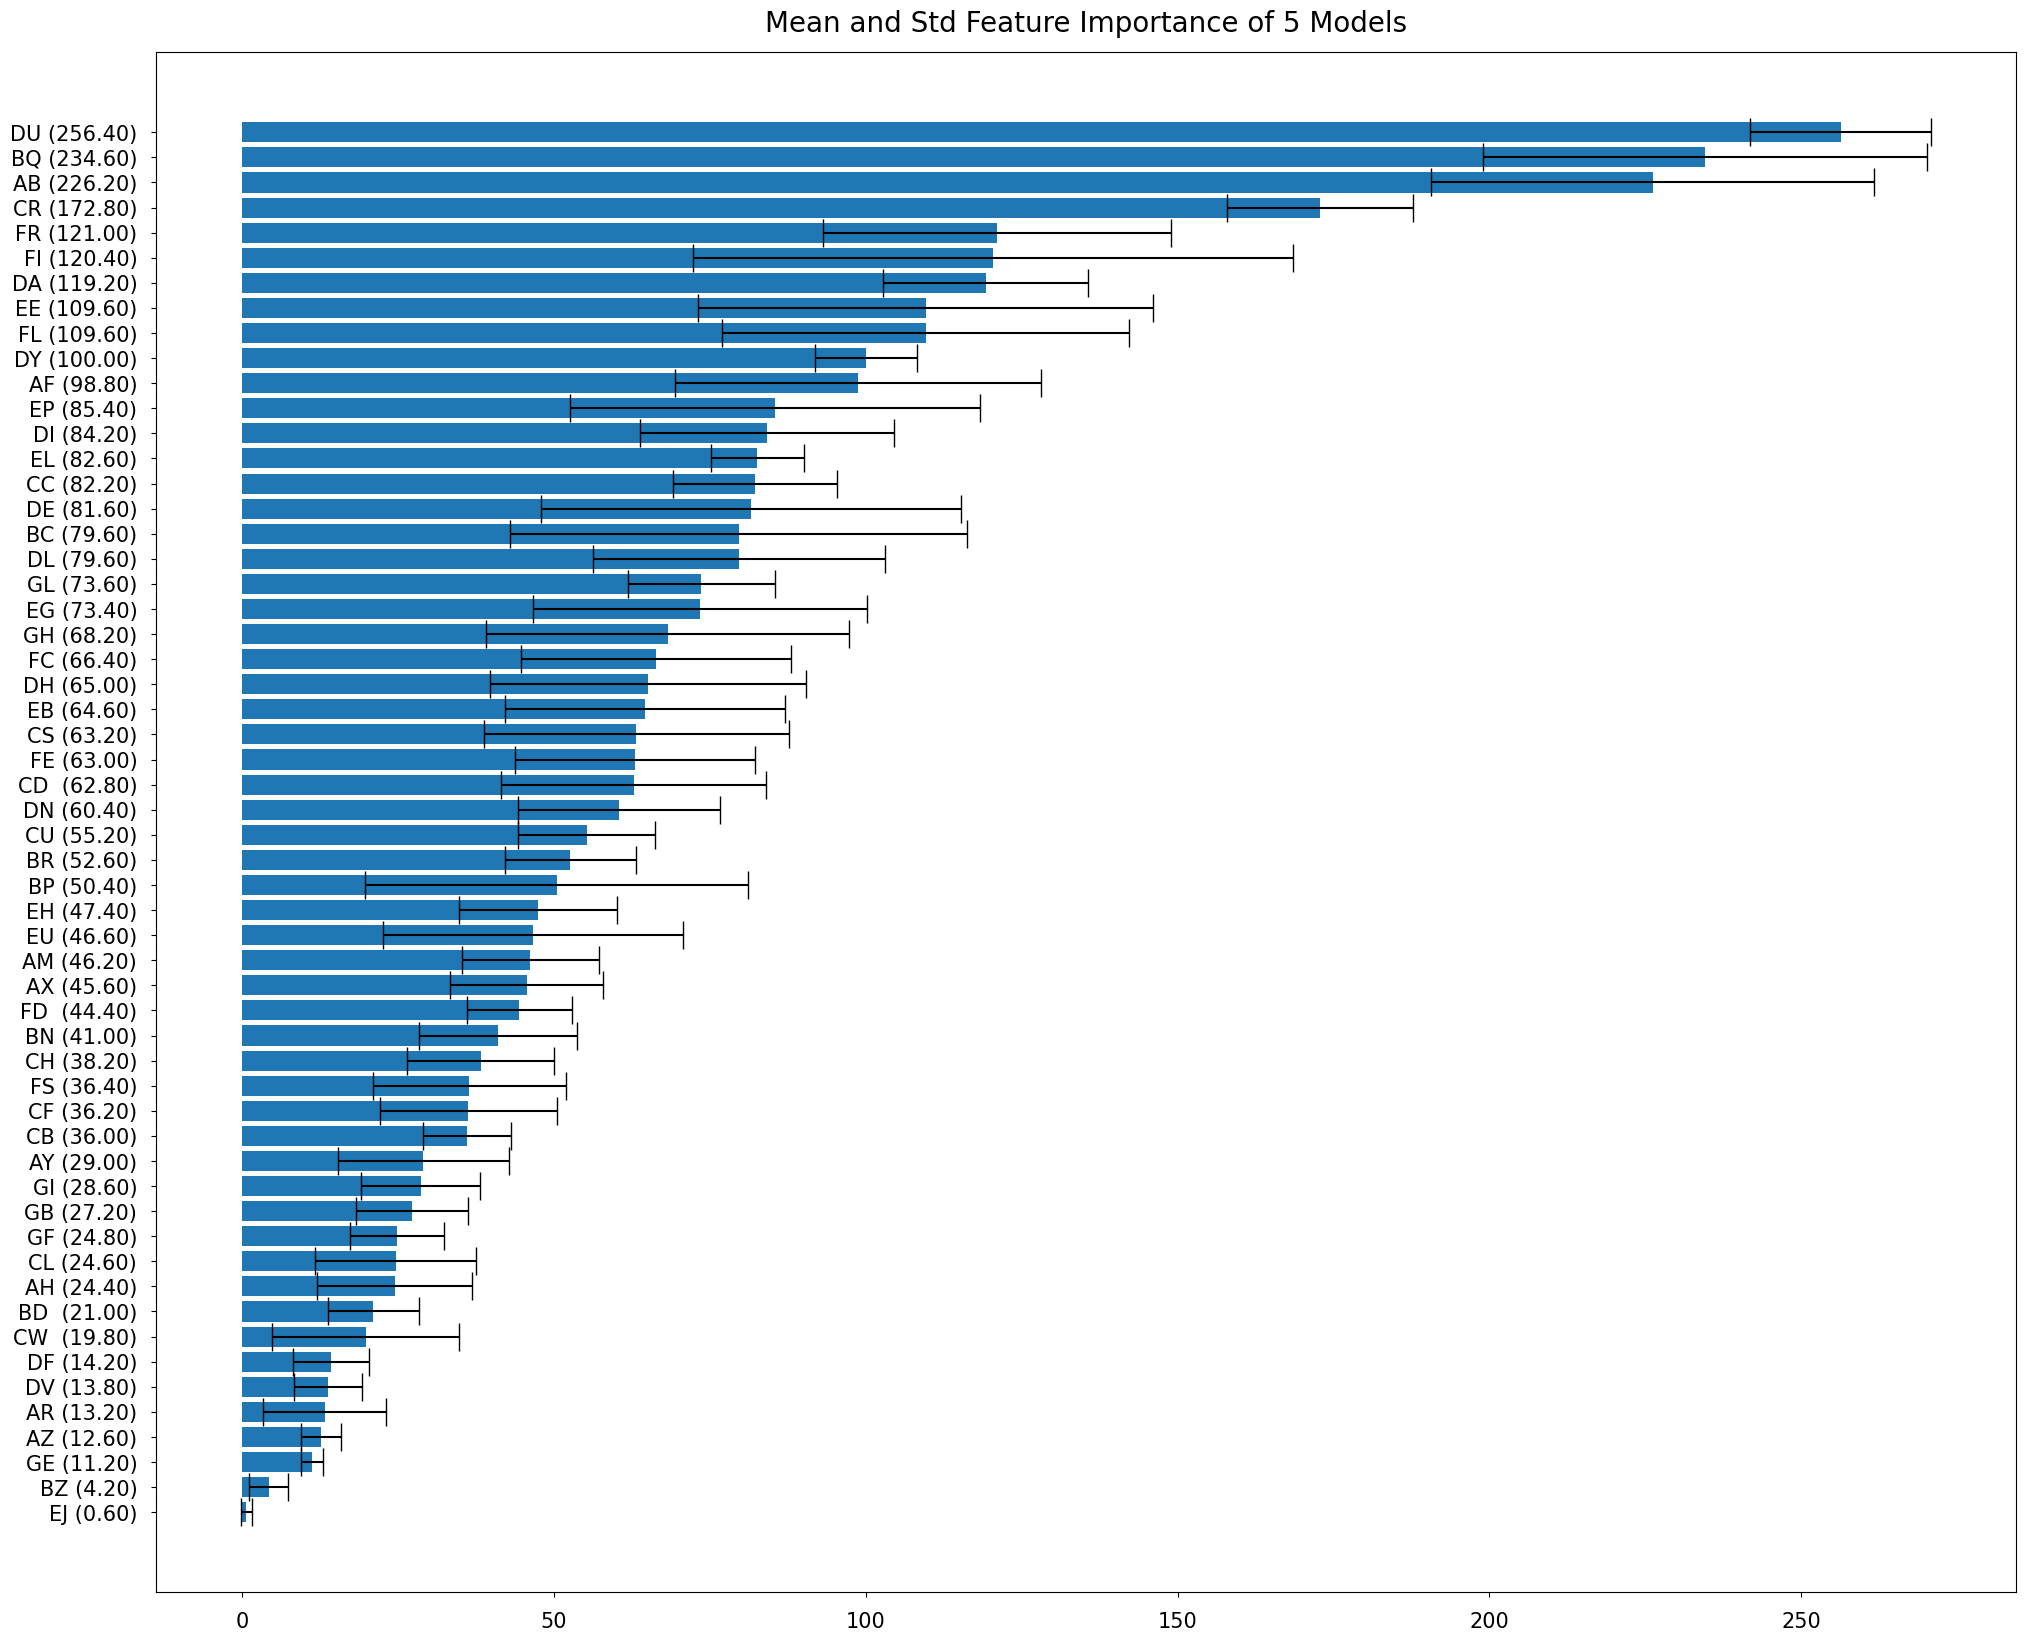

In [11]:
for importance_type, df_feature_importance in zip(['gain', 'split'], [df_feature_importance_gain, df_feature_importance_split]):
    df_feature_importance['mean'] = df_feature_importance[[f'fold_{fold}' for fold in range(1, n_splits + 1)]].mean(axis=1)
    df_feature_importance['std'] = df_feature_importance[[f'fold_{fold}' for fold in range(1, n_splits + 1)]].std(axis=1).fillna(0)
    df_feature_importance.sort_values(by='mean', ascending=False, inplace=True)
    visualize_feature_importance(df_feature_importance=df_feature_importance)
    

## 7. Submission

In [12]:
df_test['class_1'] = df_test['lightgbm_prediction']
df_test['class_0'] = 1 - df_test['class_1']
df_submission = df_test.loc[:, ['Id', 'class_0', 'class_1']]
df_submission.to_csv('submission.csv', index=False)